## Multi-Class Text Classification using transformers and TensorFlow

We will be fine-tuning a DistilBert model for the Multiclass text classification problem using a tweet dataset which was labelled manually by the Collaborators of Omdena (Marsielle Chapter) Project - Using NLP to stop online hate.

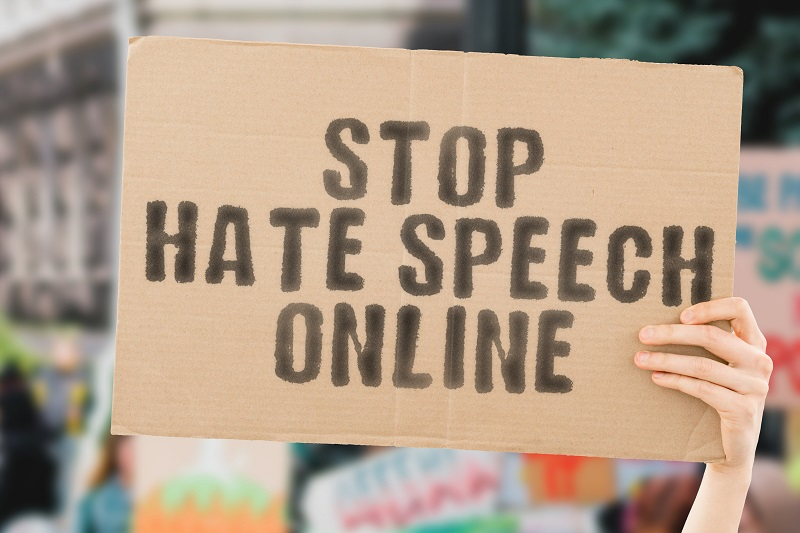

The project is designed to reduce Online Sexual Exploitation and Abuse of Children (OSEAC). With a 15,000% rise in online Child Sexual Abuse Materials (CSAM) online from 2005 to 2020, it is clear that online child violence is growing exponentially. In 2021, the National Center for Missing and Exploited Children’s CyberTipline received 29.3 million reports of CSAM, making 2021 the worst year on record for online child sexual abuse.

In [ ]:
#!pip install git+https://github.com/huggingface/transformers.git

### Importing the required libraries

In [46]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
#from transformers import DistilBertModel
from transformers import TFDistilBertModel
#import torch
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
from collections import Counter
import json
import gc
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
import random
import nltk
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
#nltk.download('omw-1.4')
#nltk.download('stopwords')
#nltk.download('wordnet')
from string import punctuation, digits
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import itertools
import warnings
warnings.filterwarnings('ignore')

Let's start coding by loading in this data using Pandas.

In [2]:
df = pd.read_csv('labeled_tweet_data_chukwudi.csv') # Change path to your download location
df.sample(5)

,Unnamed: 0,Line,created_at,user_id,text,merged_labels
584,584,3747,Sun Dec 18 08:52:10 +0000 2022,2811681426,@JLMelenchon @ManonAubryFr Alors qu elle s int...,bullying
593,593,4358,Sun Dec 18 08:35:02 +0000 2022,"1,49E+18",RT @E2Villiers: Devenez migrant l’Etat 🙌vous o...,none
563,563,4330,Sun Dec 18 08:36:15 +0000 2022,2634369052,"RT @BFMTV: ""L'Argentine, ça va être un gros mo...",bullying
2204,2205,4136,Sun Dec 18 08:41:41 +0000 2022,"1,59E+18",@yasminebouagga @dupontaignan Évitons les ambi...,none
363,363,3825,Sun Dec 18 08:50:05 +0000 2022,897803444,@Enthoven_R La croix que vous avez choisi? Cel...,bullying


In [3]:
df.shape

(2307, 6)

In [4]:
#df.rename(columns = {'Sentence':'text', 'Label':'label'}, inplace = True)

In [5]:
#df.rename(columns = {'Label':'label'}, inplace = True)

In [6]:
df.merged_labels.unique()

array(['none', 'bullying', 'racism', 'hate speech', 'homophobia',
       'sexism'], dtype=object)

only the following features are needed:
text - tweet message from a `user_id`
merged_labels - category of the tweet(`bullying`, `hate speech`, `sexist`, `homophobia`, `none`, `racism`).

In [7]:
#df['merged_labels'].unique()

So there are a total of 6 unique categories represented as strings. We need to encode them by assigning each with a unique number. The following code does that:

In [8]:
df['encoded_labels'] = df['merged_labels'].astype('category').cat.codes

In [9]:
df.head()

,Unnamed: 0,Line,created_at,user_id,text,merged_labels,encoded_labels
0,0,3631,Sun Dec 18 08:54:57 +0000 2022,3778501,RT @MSolidarites: 🔥 C'est aujourd'hui 🔥\n \n R...,none,3
1,1,5234,Sun Dec 18 08:04:43 +0000 2022,12700192,@ptiloup44 @CarrPatrick2 Pourquoi MENTEZ-VOUS ...,bullying,0
2,2,5297,Sun Dec 18 08:02:33 +0000 2022,15657767,RT @RAbsolument: Espagne : Un migrant Marocain...,none,3
3,3,4477,Sun Dec 18 08:31:26 +0000 2022,15856141,@ajplusfrancais Comment un migrant arrivant d'...,racism,4
4,4,4761,Sun Dec 18 08:21:48 +0000 2022,17654549,@Charononia Gros cadeau ça !,none,3


### Cleaning the data

In [10]:
def clean_text(data):
    """
    input: data: a dataframe containing texts to be cleaned
    return: the same dataframe with an added column of clean text
    """
    clean_data = data.copy()
    clean_data = clean_data[['text', 'encoded_labels']]
    stop_words = stopwords.words('french')
    clean_text = []
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()

    for idx in range(len(data)):
        text = clean_data['text'][idx]
        label = clean_data['encoded_labels'][idx]
        text_lowercase = text.lower()
        text_no_stopwords = " ".join([word for word in text_lowercase.split() if word not in (stop_words)])
        text_tokenized = tokenizer.tokenize(text_no_stopwords)
        text_lemmatized = [lemmatizer.lemmatize(token) for token in text_tokenized]
        clean_text = ' '.join(text_lemmatized)
        clean_data['text'][idx] = clean_text
    return clean_data

In [11]:
clean_data = clean_text(df)

The above function does the following: it reads in a dataframe, and selects the 'text' column. It will lemmatize a word if the word is not a stopword or a punctuation. This is useful because otherwise we would have a lot of superfluous, and ultimately useless, data inside our dataset. We then create a new Dataframe to avoid confusions with the trainining dataset. 

In [12]:
clean_data.head(5)

,text,encoded_labels
0,rt msolidarites c est aujourd hui rendez vous ...,3
1,ptiloup44 carrpatrick2 pourquoi mentez vous l ...,0
2,rt rabsolument espagne migrant marocain détrui...,3
3,ajplusfrancais comment migrant arrivant d alge...,4
4,charononia gros cadeau ça,3


### A littel EDA

let us find out the most common word used on these tweet messages.

In [49]:
# Counting frequently used words. 
word_list = [word for line in clean_data['text']  for word in line.split()]
sns.set(style="darkgrid")
counts = Counter(word_list).most_common(15)
count_words_df = pd.DataFrame(counts)
count_words_df.columns = ['word', 'frequency']
count_words_df.head(10)

,word,frequency
0,t,1210
1,rt,1118
2,gros,981
3,http,883
4,co,878
5,l,640
6,est,512
7,c,470
8,a,421
9,e,357


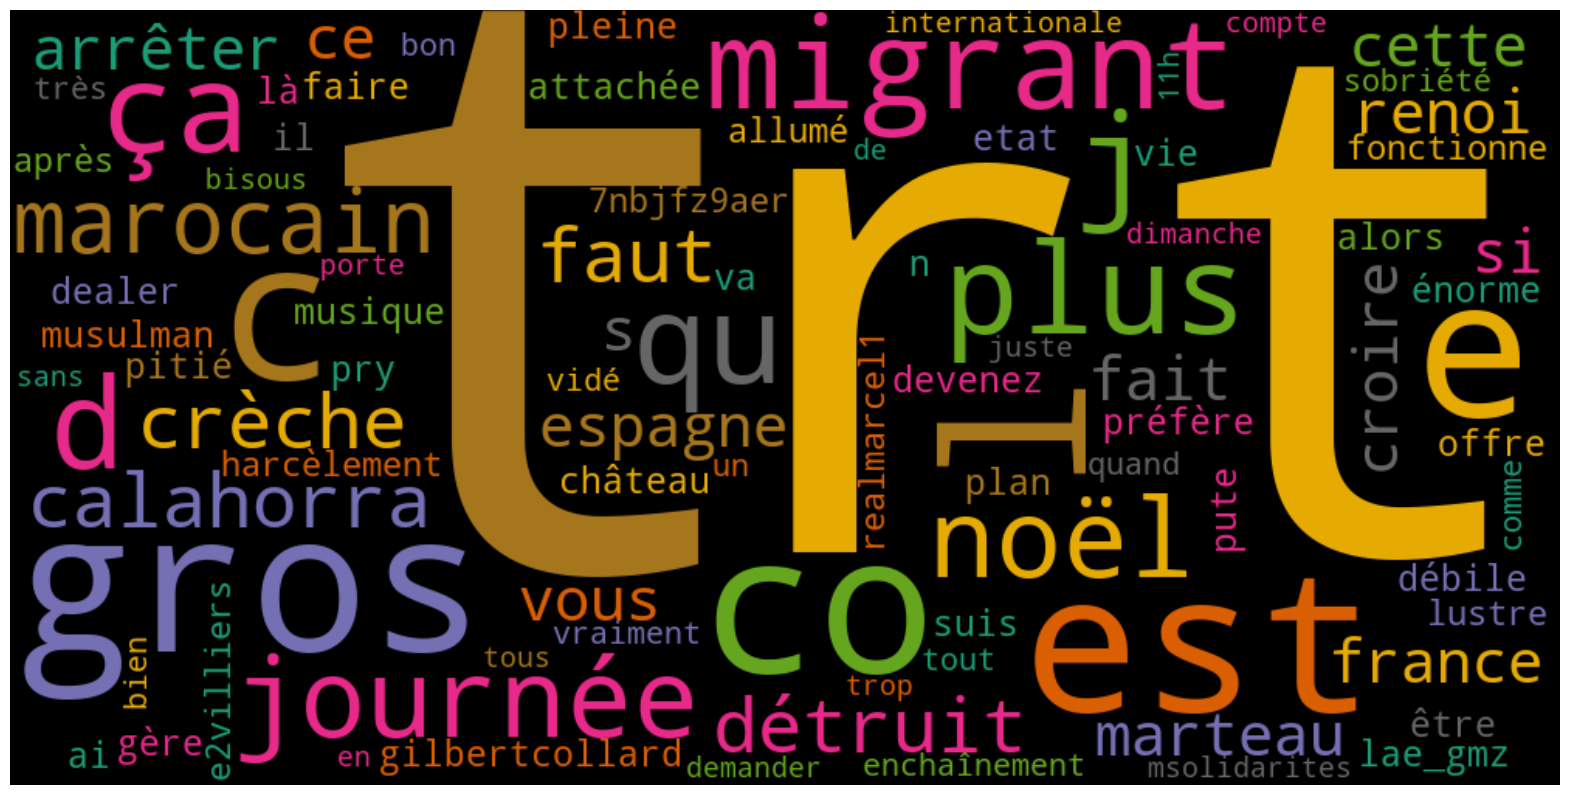

In [50]:
count_all = Counter(word_list).most_common(100)
all_words_df = pd.DataFrame(count_all)
all_words_df.columns = ['word', 'frequency']

# Creating word_cloud with text as argument in .generate() method
text = " ".join(all_words_df.word)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, width=1000, height=500, 
                       colormap='Dark2', max_font_size=1350, 
                       background_color = 'black').generate(text)
# Display the generated Word Cloud
plt.rcParams['figure.figsize'] = [20, 15]
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Define Features and Labels
Let's now define the columns that will become our features and labels, and convert them to lists.

In [13]:
data_texts = df["text"].to_list() # Features (not-tokenized yet)
data_labels = df["encoded_labels"].to_list() # Lables

The following code splits our data into training and validation sets, which we will use to train and evaluate the model. A small slice (0.01 fraction) has been taken out of the train data as test data. We will use this, not to evaluate the model, but just to test our final model later.

In [14]:
# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels,
                                                                    test_size=0.2, random_state=0)

In [15]:
# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, 
                                                                      test_size=0.01, random_state=0)

### Tokenizing with DistilBert Tokenizer

Fine-tuning in the HuggingFace's `transformers` library involves using a pre-trained model and a tokenizer that is compatible with that model's architecture and input requirements. Each pre-trained model in transformers can be accessed using the right model class and be used with the associated tokenizer class. Since we want to use DistilBert for a classification task, we will use the `DistilBertTokenizer`'s tokenizer class to tokenize our texts and then use `TFDistilBertForSequenceClassification` model class in a later section to fine-tune the pre-trained model using the output from the tokenizer.

The `DistilBertTokenizer` generates input_ids and attention_mask as outputs. This is what is required by a DistilBert model as its inputs.



In [16]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [17]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)

In [18]:
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

So, in the above code, we defined the tokenizer object using the `from_pretrained()` method which downloads and caches the tokenizer files associated with the DistilBert model. When we pass text through this tokenizer the generated output will be in the format expected by the DistilBert architecture, as stated above. We use `padding` and `truncation` to make sure all the vectors are the same size.

Now that we have our texts in an encoded form, there is only one step left before we can begin the fine-tuning process.

### Creating a Dataset object for Tensorflow

Before we can move on to the fine-tuning phase, we need to convert our input encodings and labels into a TensorFlow Dataset object. We do this by passing them to the `from_tensor_slices` constructor method.

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

Now, our data is in the right format and we can use it to fine-tune a model.

### Fine-tuning Option 1: Using native Tensorflow

We use the from_pretrained() method to initialize a pre-trained model. This will load in the weights and initialize the model with the preset configurations.

#### Building the model and compiling it

In [20]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5) 
model.compile(optimizer=optimizer, metrics=['accuracy']) #loss=model.compute_loss

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


The DistilBert model and other models available in the transformers library are standard tf.keras.Model classes (and torch.nn.Module in the case of Pytorch), and so we may use them just as we would use a model that we may have defined ourselves using the native TensorFlow and Keras API. Also, notice the num_labels=6 parameter, this is because we have a total of 5 classes.

It is also possible for us to customize the model by changing its configuration.
The data is prepared and the model is defined. Let's begin training!

In [22]:
model.fit(train_dataset.shuffle(1000).batch(16), epochs=6, batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16))

Epoch 1/6
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
115/115 [==============================] - 399s 3s/step - loss: 0.9206 - accuracy: 0.7426 - val_loss: 0.8543 - val_accuracy: 0.7468
Epoch 2/6
115/115 [==============================] - 335s 3s/step - loss: 0.7553 - accuracy: 0.7705 - val_loss: 0.7030 - val_accuracy: 0.7662
Epoch 3/6
115/115 [==============================] - 341s 3s/step - loss: 0.6209 - accuracy: 0.7924 - val_loss: 0.6718 - val_accuracy: 0.7749
Epoch 4/6
115/115 [==============================] - 355s 3s/step - loss: 0.4879 - accuracy: 0.8341 - val_loss: 0.7031 - val_accuracy: 0.7511
Epoch 5/6
115/115 [==============================] - 352s 3s/step - loss: 0.3748 - accuracy: 0.8680 - val_loss: 0.7365 - val_accuracy: 0.7641
Epoch 6/6
115/115 [==============================] - 333s 3s/step - loss: 0.3356 - accura

After 3 epochs we get an accuracy of 0.79 and a val_accuracy of 0.72. Not bad!

The model is fine-tuned and evaluated using the `train_dataset` and `val_dataset` that we created earlier. The `shuffle()` method shuffles the elements of the dataset, and `batch()` creates batches with batch_size of 16. 

Now our model is fine-tuned and is ready to be saved and used to make predictions on new data. 
The next section, however, discusses using the provided TFTrainer class, which is an alternative method to fine-tune a model in transformers.

### Fine-tuning the model (Option 2) : Using the TFTrainer class

The `TFTrainer` (Trainer for Pytorch) is a class provided by the transformers library that offers a simple, yet feature-rich, method of training and evaluating models.

The following code shows how to define the configuration settings and build a model using the TFTrainer class.

#### Defining the options for training

In [ ]:
#from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

#training_args = TFTrainingArguments(
    #output_dir='./results',          # output directory
    #num_train_epochs=3,              # total number of training epochs
    #per_device_train_batch_size=16,  # batch size per device during training
    #per_device_eval_batch_size=64,   # batch size for evaluation
    #warmup_steps=500,                # number of warmup steps for learning rate scheduler
    #weight_decay=0.01,               # strength of weight decay
    #logging_dir='./logs',            # directory for storing logs
#)

#with training_args.strategy.scope():
    #trainer_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

#trainer = TFTrainer(
    #model=trainer_model,                 # the instantiated 🤗 Transformers model to be trained
    #args=training_args,                  # training arguments, defined above
    #train_dataset=train_dataset,         # training dataset
    #eval_dataset=val_dataset,             # evaluation dataset
#)

The `TFTrainingArguments` is how we set customization arguments for the training loop and later use them in the `TFTrainer` class. We instantiate the model using the `TFDistilBertForSequenceClassification` class. And then finally, we build the model by instantiating the TFTrainer class and passing in the different options we have defined along with our datasets.

Training

In [ ]:
#trainer.train()

In [ ]:
#trainer.evaluate()

In [23]:
pd.DataFrame(model.history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.920580,0.742607,0.854313,0.746753
1,0.755346,0.770537,0.702975,0.766234
2,0.620867,0.792443,0.671753,0.774892
3,0.487880,0.834064,0.703073,0.751082
4,0.374818,0.868018,0.736478,0.764069
5,0.335593,0.897590,0.707937,0.796537


#### Visualizing model loss and accuracy

<AxesSubplot: >

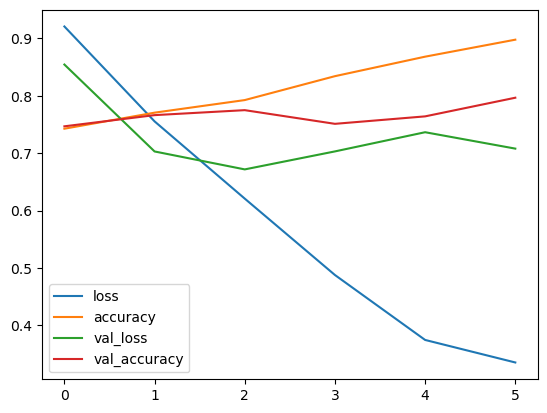

In [24]:
pd.DataFrame(model.history.history).plot()

### Saving and loading the model

After training a model, we most likely want to save it so that we can use it for inference later. The `save_pretrained()` method is used to save both the model, and the tokenizer, and all the files associated with them in a directory.

In [25]:
save_directory = "/saved_models" # change this to your preferred location

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/saved_models\\tokenizer_config.json',
 '/saved_models\\special_tokens_map.json',
 '/saved_models\\vocab.txt',
 '/saved_models\\added_tokens.json')

The `from_pretrained()` method accepts either a model name or a directory to load a model or a tokenizer. Initially, we used the model name `(distilbert-base-uncased)` to load in our desired model. This time, we will specify the directory to load the saved model.

#### Loading the model and the tokenizer

In [26]:
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at /saved_models were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /saved_models and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Note:      
When you use the `from_pretrained()` method to initialize a tokenizer or model, the library will download and cache files like the model weights file, tokenizer vocab file, and config files and save them locally. The `from_pretrained()` method allows you to specify the name of the model that it recognizes or a directory name where it can find the necessary files. You may have to choose one over the other, depending on your application. So for example, in a production environment, you may want to pre-download a model and have it always available in your filesystem.

### Making Predictions with new data
Let's now actually use our fine-tuned model on a sample text from test_text that we created earlier, and see if it can classify the text correctly.

In [27]:
#function that changes the encoded_label back to category
def predict_sentiment(num):
	if num==0:
		return 'bullying'
	elif num==1:
		return 'hate speech'
	elif num==2:
		return 'homophobia'
	elif num==3:
		return 'none'
	elif num==4:
		return 'racism'
	else:
		return 'sexism'

In [40]:
test_text = test_texts[16]
test_text

'RT @lae_gmz: « j’suis attachée mais t’es un Renoi, t’es pas musulman, tu pries pas tu préfère dealer » mais pitié qui gère la musique de We…'

##### output of actual label

In [41]:
test_label = test_labels[16]
predict_sentiment(test_label) 

'racism'

##### output of predicted label

In [42]:
predict_input = loaded_tokenizer.encode(test_text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

output = loaded_model(predict_input)[0]

prediction_value = tf.argmax(output, axis=1).numpy()[0]
predict_sentiment(prediction_value)

'racism'

### Loading the saved model in pytorch and making predictions

Let us also load this model, that was fine-tuned using TensorFlow, into Pytorch.

In [ ]:
test_text = test_texts[16]
test_text

In [ ]:
from transformers import DistilBertForSequenceClassification

loaded_tokenizer_pt = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model_pt = DistilBertForSequenceClassification.from_pretrained(save_directory, from_tf=True)

The `DistilBertForSequenceClassification` is the Pytorch equivalent class of `TFDistilBertForSequenceClassification` that we used for TensforFlow - we just have to add "TF" to get the same model in TensorFlow. We use the same `DistilBertTokenizer` class in Pytorch as we did for TensorFlow, as tokenizer classes in transformers are platform agnostic. Notice also that we added from_tf=True to specify that we want to load a model that was fine-tuned using Tensorflow. Similarly, we would have written from_pt=True, if we were loading a model trained using Pytorch into TensorFlow.

Let's test the loaded model.

In [ ]:
import torch
predict_input_pt = loaded_tokenizer_pt.encode(test_text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="pt")

output_pt = loaded_model_pt(predict_input_pt)[0]

predictions_value_pt = torch.argmax(output_pt[0], dim=-1).item()
predict_sentiment(predictions_value_pt)

We got the same result!!!

Reference:

All thanks to:
www.sunnyville.ai